In [1]:
#Author: Jeremy McMahan (jmcmahan@wisc.edu)
import os
import ujson
import ast
import numpy as np
from time import time
from gurobipy import *
import matplotlib.pyplot as plt
from collections import namedtuple
MDP = namedtuple('MDP', 'S A P r H s0')
plt.rcParams["font.size"] = "12"
plt.rcParams['lines.linewidth'] = 3

# 0. NP-hard MDP Generation

In [2]:
#Generates the N random reward/cost variations of the Np-hard path MDP for each H from 1 to Hmax
#and saves them to the desired folder.
def gen_hard_acmdps(Hmax, N):
    for H in range(1, Hmax+1):
        S = {h: [0] for h in range(H)}
        A = {(h,0): [0,1] for h in range(H)}
        P = {(h,0,a,0): 1 for h in range(H) for a in range(2)}
        s0 = 0
        for i in range(N):
            r0 = {(h,0,0) : 0 for h in range(H)} #Do nothing action
            c0 = {(h,0,0) : 0 for h in range(H)} #Do nothing action
            r1 = {(h,0,1) : np.random.uniform(0,1) for h in range(H)}
            c1 = {(h,0,1) : np.random.uniform(0,1) for h in range(H)}
            r = r0 | r1
            c = c0 | c1
            M = MDP(S,A,P,r,H,s0)
            ujson.dump(M._asdict(), open('data/acMDP' + str((H,i)) + '.txt', 'w'))
            ujson.dump(c, open('data/cost' + str((H,i)) + '.txt', 'w'))

In [3]:
#gen_hard_acmdps(100, 10)

In [4]:
#Reads an MDP from file
def get_acmdp(H, i):
    sM = MDP(**ujson.load(open('data/acMDP' + str((H,i)) + '.txt')))
    S = {}
    A = {}
    P = {}
    r = {}
    c = {}
    s0 = sM.s0
    for key in sM.S:
        S[ast.literal_eval(key)] = sM.S[key]
    for key in sM.A:
        A[ast.literal_eval(key)] = sM.A[key]
    for key in sM.P:
        P[ast.literal_eval(key)] = sM.P[key]
    for key in sM.r:
        r[ast.literal_eval(key)] = sM.r[key]
    sc = ujson.load(open('data/cost' + str((H,i)) + '.txt'))
    for key in sc:
        c[ast.literal_eval(key)] = sc[key]
    M = MDP(S,A,P,r,H,s0)
    return M, c

In [5]:
#get optimal value and optimal policy via standard backward induction
def opt(M):
    V = {} 
    pi = {} 
    for s in M.S[M.H-1]:
        cur = {a: M.r[M.H-1,s,a] for a in M.A[M.H-1,s]}
        V[M.H-1, s] = max(cur.values())
        pi[M.H-1, s] = max(cur, key = cur.get)
    for h in range(M.H-2,-1,-1):
        for s in M.S[h]:
            cur = {a: (M.r[h,s,a] + sum([M.P[h,s,a,s_p]*V[h+1,s_p] for s_p in M.S[h+1] if (h,s,a,s_p) in M.P])) for a in M.A[h,s]}
            V[h,s] = max(cur.values())
            pi[h,s] = max(cur, key = cur.get)
    return V[0,M.s0],pi

# Algorithms

In [6]:
#The cost-augmented MDP as defined in the main paper (Def 1).
def cost_mdp(M,c,B):
    cS = {}
    cA = {}
    cP = {}
    cS[0] = {(M.s0, 0)}
    for h in range(1,M.H+1):
        cS[h] = []
        for (s,cp) in cS[h-1]:
            cA[h-1,(s,cp)] = []
            for a in M.A[h-1,s]:
                c_p = cp + c[h-1,s,a]
                if c_p <= B:
                    if a not in cA[h-1,(s,cp)]:
                        cA[h-1,(s,cp)].append(a)
                    if h == M.H:
                        continue
                    for s_p in M.S[h]:
                        if M.P[h-1,s,a,s_p] > 0:
                            cP[h-1,(s,cp),a,(s_p,c_p)] = M.P[h-1,s,a,s_p]
                            if (s_p,c_p) not in cS[h]:
                                cS[h].append((s_p,c_p))
    cr = {(h,(s,cp),a) : M.r[h,s,a] for h in range(M.H) for (s,cp) in cS[h] for a in cA[h,(s,cp)]}
    cs0 = (M.s0, 0)
    cM = MDP(cS, cA, cP, cr, M.H, cs0)
    return cM

In [7]:
def reduction(M, c, B):
    return opt(cost_mdp(M, c, B))

In [8]:
def trunc_reduction(M, c, B, k):
    c_trunc = {}
    for key in c:
        c_trunc[key] = np.round(c[key], k)
    return opt(cost_mdp(M, c_trunc, B))

In [9]:
def approximation(M, c, B, eps):
    u = eps*B/M.H
    B_approx = int(np.floor(B/u))
    c_approx = {k : int(np.floor(c[k]/u)) for k in c}
    M_eps = cost_mdp(M, c_approx, B_approx)
    return opt(M_eps)

In [10]:
def no_violation(M, c, B, eps):
    B = B/(1+eps)
    u = eps*B/M.H
    B_approx = int(np.floor(B/u))
    c_approx = {k : int(np.floor(c[k]/u)) for k in c}
    M_eps = cost_mdp(M, c_approx, B_approx)
    return opt(M_eps)

# 1. Experiment: Approximation Scheme Performance

In [11]:
Hmax = 14
skip = 2
Hs = list(range(skip,Hmax+1,skip))
N = 5
Bs = [.1, 10]
eps = .1

In [12]:
reduct = {(H,B): [] for H in Hs for B in Bs}
approx = {(H,B): [] for H in Hs for B in Bs}
reduct_time = {(H,B): [] for H in Hs for B in Bs}
approx_time = {(H,B): [] for H in Hs for B in Bs}
for H in Hs:
    for B in Bs:
        for i in range(N):
            M,c = get_acmdp(H,i)
            
            #Reduction
            start = time()
            reduct[H,B].append(reduction(M,c,B)[0])
            end = time()
            reduct_time[H,B].append(end - start)
            
            #Approximation
            start = time()
            approx[H,B].append(approximation(M,c,B,eps)[0])
            end = time()
            approx_time[H,B].append(end - start)

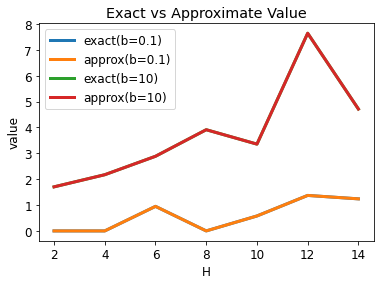

In [13]:
index = {(H,B): np.argmax(np.array(approx[H,B]) - np.array(reduct[H,B])) for H in Hs for B in Bs}

for B in Bs:
    plt.plot(Hs, [reduct[H,B][index[H,B]] for H in Hs], label='exact(b='+str(B)+')')
    plt.plot(Hs, [approx[H,B][index[H,B]] for H in Hs], label='approx(b='+str(B)+')')
plt.legend()
plt.xlabel('H')
plt.ylabel('value')
plt.title('Exact vs Approximate Value')
plt.savefig('results/approx_value' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

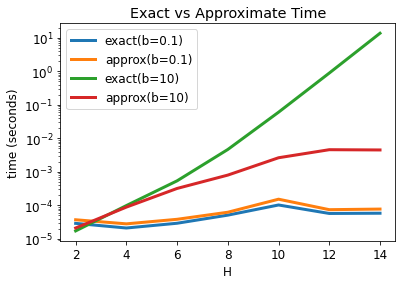

In [14]:
index = {(H,B): np.argmin(np.array(reduct_time[H,B]) - np.array(approx_time[H,B])) for H in Hs for B in Bs}

for B in Bs:
    plt.plot(Hs, [reduct_time[H,B][index[H,B]] for H in Hs], label='exact(b='+str(B)+')')
    plt.plot(Hs, [approx_time[H,B][index[H,B]] for H in Hs], label='approx(b='+str(B)+')')

plt.legend()
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.yscale('log')
plt.title('Exact vs Approximate Time')
plt.savefig('results/approx_time' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

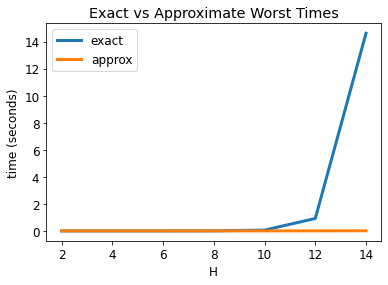

In [15]:
#Compare the worst-case running times for both methods
worst_reduct = [np.max([np.max(reduct_time[H,B]) for B in Bs]) for H in Hs]
worst_approx = [np.max([np.max(approx_time[H,B]) for B in Bs]) for H in Hs]
plt.plot(Hs, worst_reduct, label='exact')
plt.plot(Hs, worst_approx, label='approx')
plt.legend()
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.title('Exact vs Approximate Worst Times')
plt.savefig('results/worst_approx_time' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

# 2. Experiment: No-Violation Scheme Performance

In [16]:
Hmax = 14
skip = 2
Hs = list(range(skip,Hmax+1,skip))
N = 5
Bs = [.1, 10]
eps = .1

In [17]:
reduct = {(H,B): [] for H in Hs for B in Bs}
noviol = {(H,B): [] for H in Hs for B in Bs}
reduct_time = {(H,B): [] for H in Hs for B in Bs}
noviol_time = {(H,B): [] for H in Hs for B in Bs}
for H in Hs:
    for B in Bs:
        for i in range(N):
            M,c = get_acmdp(H,i)
            
            #Reduction
            start = time()
            reduct[H,B].append(reduction(M,c,B)[0])
            end = time()
            reduct_time[H,B].append(end - start)
            
            #No-Violation
            start = time()
            noviol[H,B].append(no_violation(M,c,B,eps)[0])
            end = time()
            noviol_time[H,B].append(end - start)

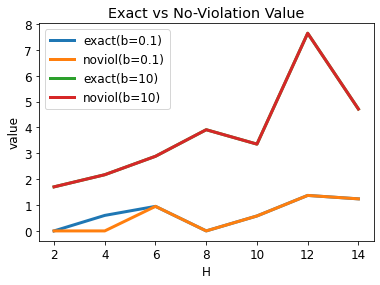

In [18]:
index = {(H,B): np.argmax(np.array(reduct[H,B]) - np.array(noviol[H,B])) for H in Hs for B in Bs}

for B in Bs:
    plt.plot(Hs, [reduct[H,B][index[H,B]] for H in Hs], label='exact(b='+str(B)+')')
    plt.plot(Hs, [noviol[H,B][index[H,B]] for H in Hs], label='noviol(b='+str(B)+')')
plt.legend()
plt.xlabel('H')
plt.ylabel('value')
plt.title('Exact vs No-Violation Value')
plt.savefig('results/noviol_value' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

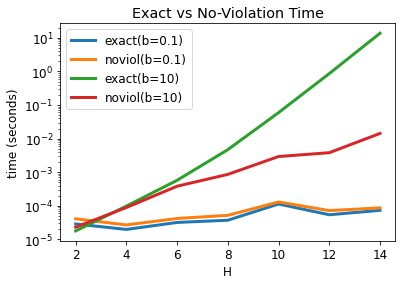

In [19]:
index = {(H,B): np.argmin(np.array(reduct_time[H,B]) - np.array(noviol_time[H,B])) for H in Hs for B in Bs}

for B in Bs:
    plt.plot(Hs, [reduct_time[H,B][index[H,B]] for H in Hs], label='exact(b='+str(B)+')')
    plt.plot(Hs, [noviol_time[H,B][index[H,B]] for H in Hs], label='noviol(b='+str(B)+')')

plt.legend()
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.yscale('log')
plt.title('Exact vs No-Violation Time')
plt.savefig('results/noviol_time' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

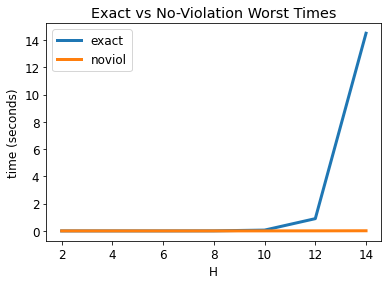

In [20]:
#Compare the worst-case running times for both methods
worst_reduct = [np.max([np.max(reduct_time[H,B]) for B in Bs]) for H in Hs]
worst_noviol = [np.max([np.max(approx_time[H,B]) for B in Bs]) for H in Hs]
plt.plot(Hs, worst_reduct, label='exact')
plt.plot(Hs, worst_noviol, label='noviol')
plt.legend()
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.title('Exact vs No-Violation Worst Times')
plt.savefig('results/worst_noviol_time' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

# 3. Experiment: Approximation vs No-Violation 

In [33]:
Hmax = 50
skip = 10
Hs = list(range(skip,Hmax+1,skip))
N = 10
Bs = [.1, 10]
eps = .1

In [34]:
noviol = {(H,B): [] for H in Hs for B in Bs}
approx = {(H,B): [] for H in Hs for B in Bs}
noviol_time = {(H,B): [] for H in Hs for B in Bs}
approx_time = {(H,B): [] for H in Hs for B in Bs}
for H in Hs:
    for B in Bs:
        for i in range(N):
            M,c = get_acmdp(H,i)
            
            #No Violation
            start = time()
            noviol[H,B].append(no_violation(M,c,B,eps)[0])
            end = time()
            noviol_time[H,B].append(end - start)
            
            #Approximation
            start = time()
            approx[H,B].append(approximation(M,c,B,eps)[0])
            end = time()
            approx_time[H,B].append(end - start)

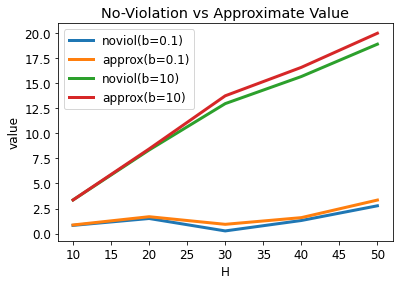

In [35]:
index = {(H,B): np.argmax(np.array(approx[H,B]) - np.array(noviol[H,B])) for H in Hs for B in Bs}

for B in Bs:
    plt.plot(Hs, [noviol[H,B][index[H,B]] for H in Hs], label='noviol(b='+str(B)+')')
    plt.plot(Hs, [approx[H,B][index[H,B]] for H in Hs], label='approx(b='+str(B)+')')
plt.legend()
plt.xlabel('H')
plt.ylabel('value')
plt.title('No-Violation vs Approximate Value')
plt.savefig('results/noviol_approx_value' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

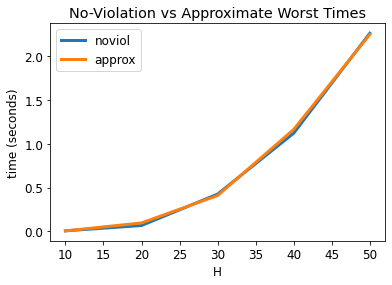

In [36]:
#Compare the worst-case running times for both methods
worst_noviol = [np.max([np.max(noviol_time[H,B]) for B in Bs]) for H in Hs]
worst_approx = [np.max([np.max(approx_time[H,B]) for B in Bs]) for H in Hs]
plt.plot(Hs, worst_noviol, label='noviol')
plt.plot(Hs, worst_approx, label='approx')
plt.legend()
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.title('No-Violation vs Approximate Worst Times')
plt.savefig('results/worst_noviol_approx_time' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

# 4. Experiment: Approximate Speed Scalability

In [25]:
Hmax = 100
skip = 10
Hs = list(range(skip,Hmax+1,skip))
N = 10
Bs = [100]
eps = .1

In [26]:
approx_time = {(H,B): [] for H in Hs for B in Bs}
for H in Hs:
    for B in Bs:
        for i in range(N):
            M,c = get_acmdp(H,i)
            
            #Approximation
            start = time()
            approximation(M,c,B,eps)
            end = time()
            approx_time[H,B].append(end - start)

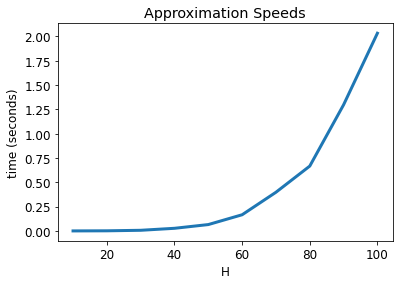

In [27]:
index = {H : np.max([np.max(approx_time[H,B]) for B in Bs]) for H in Hs}

plt.plot(Hs, [index[H] for H in Hs])
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.title('Approximation Speeds')
plt.savefig('results/approx_scale' + str((Hmax,N,Bs,eps)) + '.png',dpi=300,bbox_inches = "tight")
plt.show()

In [28]:
M,c = get_acmdp(15,0)
start = time()
reduction(M,c,15)
end = time()
print(end - start)

58.76941108703613


### Output: 57.13721799850464

# 5. Experiment: Precision vs Speed Tradeoff

In [29]:
Hmax = 12
skip = 2
Hs = list(range(skip,Hmax+1,skip))
N = 5
B = 4
Ks = [2,4,8,32]

In [30]:
trunc = {(H,k): [] for H in Hs for k in Ks}
trunc_time = {(H,k): [] for H in Hs for k in Ks}
for H in Hs:
    for k in Ks:
        for i in range(N):
            M,c = get_acmdp(H,i)

            #Reduction
            start = time()
            trunc[H,k].append(trunc_reduction(M,c,B,k)[0])
            end = time()
            trunc_time[H,k].append(end - start)

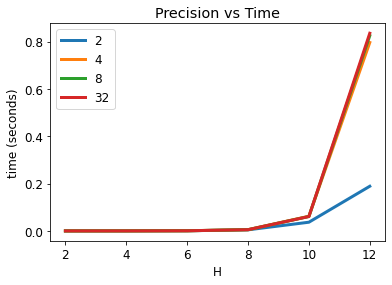

In [31]:
for k in Ks:
    plt.plot(Hs, [np.max(trunc_time[H, k]) for H in Hs], label=str(k))
plt.legend()
plt.xlabel('H')
plt.ylabel('time (seconds)')
plt.title('Precision vs Time')
plt.savefig('results/precision_times' + str((Hmax,N,B,Ks)) + '.png',dpi=300)
plt.show()

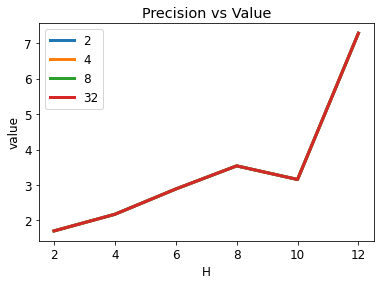

In [32]:
for k in Ks:
    index = [trunc[H,k][np.argmax(np.array(trunc[H,32])-np.array(trunc[H,k]))] for H in Hs]
    plt.plot(Hs, index, label=str(k))
plt.legend()
plt.xlabel('H')
plt.ylabel('value')
plt.title('Precision vs Value')
plt.savefig('results/precision_values' + str((Hmax,N,B,Ks)) + '.png',dpi=300)
plt.show()